<a href="https://colab.research.google.com/github/ngildersleeve/waste-classification/blob/main/Project_Classify_Waste_Products_Using_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Introduction
In this project, you will classify waste products using transfer learning.

##Project Overview
EcoClean currently lacks an efficient and scalable method to automate the waste sorting process. The manual sorting of waste is not only labor-intensive but also prone to errors, leading to contamination of recyclable materials. The goal of this project is to leverage machine learning and computer vision to automate the classification of waste products, improving efficiency and reducing contamination rates. The project will use transfer learning with a pre-trained VGG16 model to classify images.

##Aim of the Project
The aim of the project is to develop an automated waste classification model that can accurately differentiate between recyclable and organic waste based on images. By the end of this project, you will have trained, fine-tuned, and evaluated a model using transfer learning, which can then be applied to real-world waste management processes.

##Final Output: A trained model that classifies waste images into recyclable and organic categories.



In [ ]:
import numpy as np
import os
# import random, shutil
import glob


from matplotlib import pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread

# from os import makedirs,listdir
# from shutil import copyfile
# from random import seed
# from random import random

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications import InceptionV3
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

## Importing Data

In [ ]:
import requests
import zipfile
from tqdm import tqdm

url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/kd6057VPpABQ2FqCbgu9YQ/o-vs-r-split-reduced-1200.zip"
file_name = "o-vs-r-split-reduced-1200.zip"

print("Downloading file")
with requests.get(url, stream=True) as response:
    response.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)


def extract_file_with_progress(file_name):
    print("Extracting file with progress")
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        members = zip_ref.infolist()
        with tqdm(total=len(members), unit='file') as progress_bar:
            for member in members:
                zip_ref.extract(member)
                progress_bar.update(1)
    print("Finished extracting file")


extract_file_with_progress(file_name)

print("Finished extracting file")
os.remove(file_name)

Extracting file with progress


100%|██████████| 1207/1207 [00:00<00:00, 6396.84file/s]

Finished extracting file
Finished extracting file


##Define configuration options

In [ ]:
img_rows, img_cols = 150, 150
batch_size = 32
n_epochs = 10
n_classes = 2
val_split = 0.2
verbosity = 1
path = 'o-vs-r-split/train/'
path_test = 'o-vs-r-split/test/'
input_shape = (img_rows, img_cols, 3)
labels = ['O', 'R']
seed = 42

## Image Data Generators

In [ ]:
# Create ImageDataGenerators for training and validation and testing
train_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
	width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size,
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'training'
)

Found 800 images belonging to 2 classes.


In [ ]:
val_generator = val_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size,
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'validation'
)

Found 200 images belonging to 2 classes.


Create a test_generator using the test_datagen object




In [ ]:
#Test generator

test_generator = test_datagen.flow_from_directory(
    directory = path_test,
    class_mode = 'binary',
    seed = seed,
    batch_size = batch_size,
    shuffle = False,
    target_size = (img_rows, img_cols)
)

Found 200 images belonging to 2 classes.


##Print the length of the train_generator

In [ ]:
print("Length of train generator: ",len(train_generator))
#

Length of train generator:  25


Look at a few augmented images.

Labels: [np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O')]


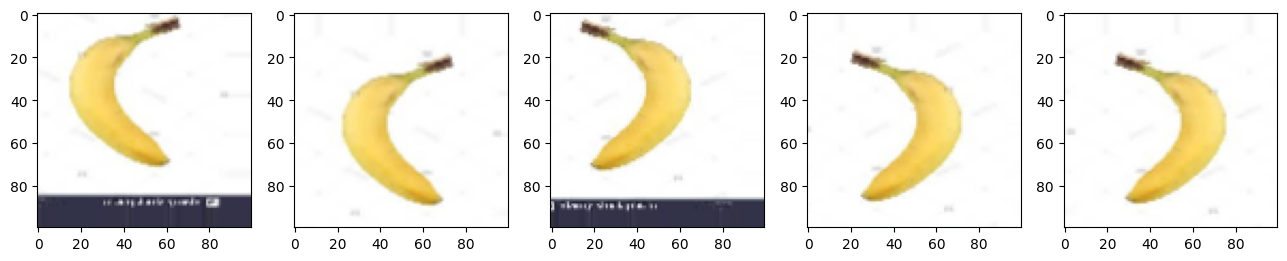

In [ ]:
from pathlib import Path

IMG_DIM = (100, 100)

train_files = glob.glob('./o-vs-r-split/train/O/*')
train_files = train_files[:20]
train_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [Path(fn).parent.name for fn in train_files]

img_id = 0
O_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
O = [next(O_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in O])
l = [ax[i].imshow(O[i][0][0]) for i in range(0,5)]

In [ ]:
from tensorflow.keras.applications import vgg16

input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

In [ ]:
for layer in basemodel.layers:
    layer.trainable = False

In [ ]:
input_shape = basemodel.output_shape[1]

model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

## Print the summary of the model
Upload the screenshot of the code and output of the summary of the model model_summary.png.


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional (Functional)              │ (None, 8192)                │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,172,673 (73.14 MB)

 Trainable params: 4,457,985 (17.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

##  Compile the model


In [ ]:
for layer in basemodel.layers:
  layer.trainable = False

model.compile(loss = 'binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])


Early Stopping

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler


checkpoint_path='O_R_tlearn_vgg16.keras'

#define set decay function

class LossHistory_(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(epoch))
        print('lr:', exp_decay(len(self.losses)))

def exp_decay(epoch):
    initial_lrate = 1e-4
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate

# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'val_loss',
                    patience = 4,
                    mode = 'min',
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

## Fit and train model

In [ ]:
extract_feat_model = model.fit(train_generator,
                               steps_per_epoch=5,
                               epochs=10,
                               callbacks = callbacks_list_,
                               validation_data=val_generator,
                               validation_steps=val_generator.samples // batch_size,
                               verbose=1)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.4988 - loss: 0.7549lr: 9.048374180359596e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 956ms/step - accuracy: 0.5083 - loss: 0.7468 - val_accuracy: 0.5312 - val_loss: 0.6849 - learning_rate: 1.0000e-04
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.5902 - loss: 0.6652lr: 8.187307530779819e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step - accuracy: 0.5939 - loss: 0.6601 - val_accuracy: 0.7917 - val_loss: 0.5181 - learning_rate: 9.0484e-05
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7592 - loss: 0.5572lr: 7.408182206817179e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - accuracy: 0.7566 - loss: 0.5550 - val_accuracy: 0.7917 - val_loss: 0.4868 - learning_rate: 8.1873e-05
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7108 - loss: 0.5569lr: 6.703200460356394e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - accuracy: 0.7090 - loss: 0.5569 - val_accuracy: 0.8281 - val_loss: 0.4302 - learning_rate: 7.408

## Plot loss curves for training and validation sets( extract_feat_model)

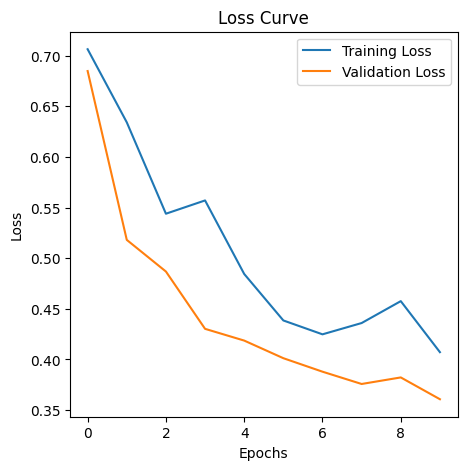

In [ ]:
import matplotlib.pyplot as plt

history = extract_feat_model

# plot loss curve
plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

##  Plot accuracy curves for training and validation sets (extract_feat_model)


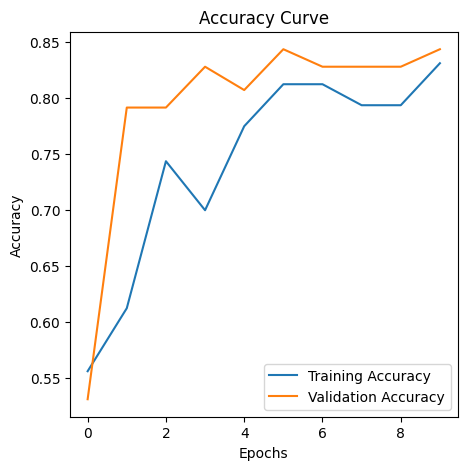

In [ ]:
# plot accuracy curve
plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Fine-Tuning model
Fine-tuning is an optional step in transfer learning, it usually ends up improving the performance of the model.

We unlock the final convolution layer to make it trainable.

In [ ]:
from tensorflow.keras.applications import vgg16

input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)

output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

for layer in basemodel.layers:
    layer.trainable = False

display([layer.name for layer in basemodel.layers])

set_trainable = False

for layer in basemodel.layers:
    if layer.name in ['block5_conv3']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in basemodel.layers:
    print(f"{layer.name}: {layer.trainable}")

['input_layer_2',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool',
 'flatten_1']

input_layer_2: False
block1_conv1: False
block1_conv2: False
block1_pool: False
block2_conv1: False
block2_conv2: False
block2_pool: False
block3_conv1: False
block3_conv2: False
block3_conv3: False
block3_pool: False
block4_conv1: False
block4_conv2: False
block4_conv3: False
block4_pool: False
block5_conv1: False
block5_conv2: False
block5_conv3: True
block5_pool: True
flatten_1: True


In [ ]:
model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

checkpoint_path='O_R_tlearn_fine_tune_vgg16.keras'

# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'val_loss',
                    patience = 4,
                    mode = 'min',
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

fine_tune_model = model.fit(train_generator,
                    steps_per_epoch=5,
                    epochs=10,
                    callbacks = callbacks_list_,
                    validation_data=val_generator,
                    validation_steps=val_generator.samples // batch_size,
                    verbose=1)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.5694 - loss: 0.7534lr: 9.048374180359596e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 533ms/step - accuracy: 0.5714 - loss: 0.7522 - val_accuracy: 0.7812 - val_loss: 0.5134 - learning_rate: 1.0000e-04
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.7161 - loss: 0.5366lr: 8.187307530779819e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step - accuracy: 0.7114 - loss: 0.5378 - val_accuracy: 0.7865 - val_loss: 0.4641 - learning_rate: 9.0484e-05
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7841 - loss: 0.5284lr: 7.408182206817179e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - accuracy: 0.7846 - loss: 0.5273 - val_accuracy: 0.8438 - val_loss: 0.3920 - learning_rate: 8.1873e-05
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8478 - loss: 0.3961lr: 6.703200460356394e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8492 - loss: 0.3938 - val_accuracy: 0.7500 - val_loss: 0.4472 - learning_rate: 7.4082

##  Plot loss curves for training and validation sets (fine tune model)


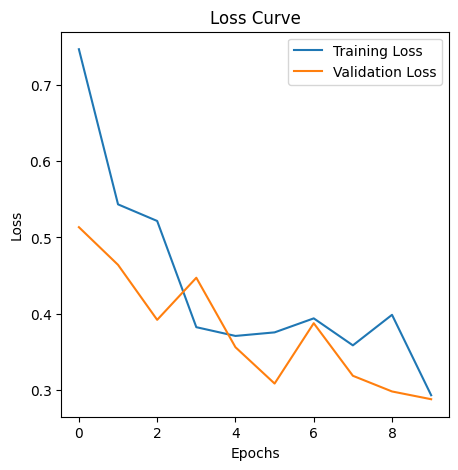

In [ ]:
history = fine_tune_model

## Task 7: Plot loss curves for training and validation sets (fine tune model)
plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

##  Plot accuracy curves for training and validation sets (fine tune model)


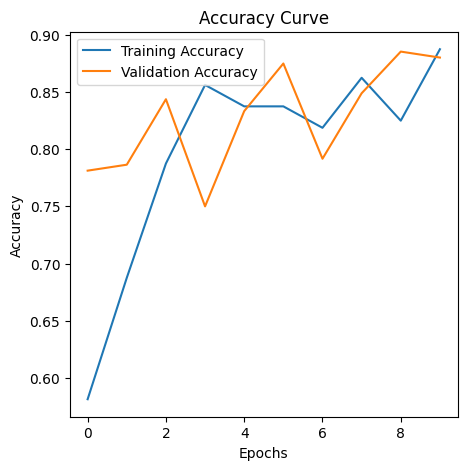

In [ ]:
history = fine_tune_model

# Task 8: Plot accuracy curves for training and validation sets  (fine tune model)

plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Evaluate both models on test data

In [ ]:
from pathlib import Path

# Load saved models
extract_feat_model = tf.keras.models.load_model('O_R_tlearn_vgg16.keras')
fine_tune_model = tf.keras.models.load_model('O_R_tlearn_fine_tune_vgg16.keras')

IMG_DIM = (150, 150)

# Load test images
test_files_O = glob.glob('./o-vs-r-split/test/O/*')
test_files_R = glob.glob('./o-vs-r-split/test/R/*')
test_files = test_files_O[:50] + test_files_R[:50]

test_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [Path(fn).parent.name for fn in test_files]

# Standardize
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

class2num_lt = lambda l: [0 if x == 'O' else 1 for x in l]
num2class_lt = lambda l: ['O' if x < 0.5 else 'R' for x in l]

test_labels_enc = class2num_lt(test_labels)

# Make predictions for both models
predictions_extract_feat_model = extract_feat_model.predict(test_imgs_scaled, verbose=0)
predictions_fine_tune_model = fine_tune_model.predict(test_imgs_scaled, verbose=0)

# Convert predictions to class labels
predictions_extract_feat_model = num2class_lt(predictions_extract_feat_model)
predictions_fine_tune_model = num2class_lt(predictions_fine_tune_model)

# Print classification report for both models
print('Extract Features Model')
print(metrics.classification_report(test_labels, predictions_extract_feat_model))
print('Fine-Tuned Model')
print(metrics.classification_report(test_labels, predictions_fine_tune_model))


Extract Features Model
              precision    recall  f1-score   support

           O       0.84      0.76      0.80        50
           R       0.78      0.86      0.82        50

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100

Fine-Tuned Model
              precision    recall  f1-score   support

           O       0.83      0.80      0.82        50
           R       0.81      0.84      0.82        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100



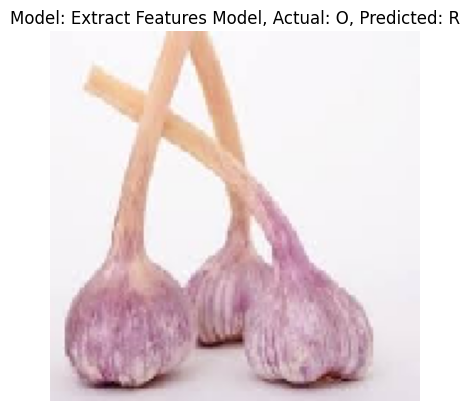

In [ ]:
# Plot one of the images with actual label and predicted label as title
def plot_image_with_title(image, model_name, actual_label, predicted_label):
    plt.imshow(image)
    plt.title(f"Model: {model_name}, Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

# Specify index of image to plot, for example index 0
index_to_plot = 0
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Extract Features Model',
    actual_label=test_labels[index_to_plot],
    predicted_label=predictions_extract_feat_model[index_to_plot],
    )

## Plot a test image using Extract Features Model (index_to_plot = 1)


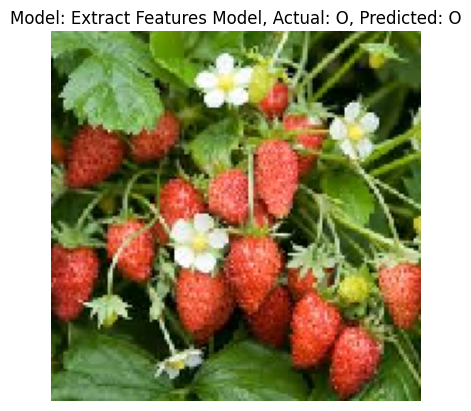

In [ ]:
index_to_plot = 1
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Extract Features Model',
    actual_label=test_labels[index_to_plot],
    predicted_label=predictions_extract_feat_model[index_to_plot],
    )

## Plot a test image using Fine-Tuned Model (index_to_plot = 1)


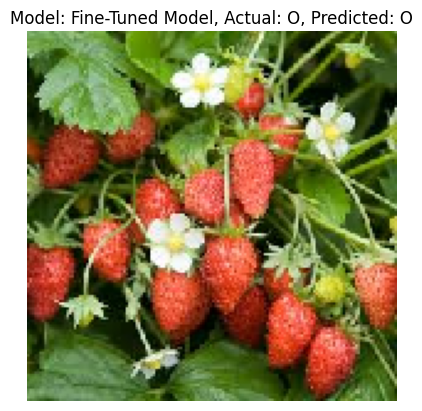

In [ ]:
# Task 10: Plot a test image using Fine-Tuned Model (index_to_plot = 1)
index_to_plot = 1
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Fine-Tuned Model',
    actual_label=test_labels[index_to_plot],
    predicted_label=predictions_fine_tune_model[index_to_plot],
    )